In [1]:
import numpy as np 
import pandas as pd 
import torch
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import evaluate, train_and_eval, summarize_results, plot_single_learning_curve, load_experiment_log
import pickle as pkl 
from datetime import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# params required for generating data loaders 

SRC_LANG = 'vi'
TARG_LANG = 'en'

SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

BATCH_SIZE = 64 

In [3]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [4]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [5]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [6]:
# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0 
DEC_DROPOUT = 0  
ATTENTION_TYPE = 'without'

# training params  
NUM_EPOCHS = 10 
LR = 0.00015 
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model and experiment 
if NETWORK_TYPE == 'rnn': 
    EXPERIMENT_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    EXPERIMENT_NAME = '{}-cnn'.format(SRC_LANG)
MODEL_NAME = '{}-{}'.format(EXPERIMENT_NAME, datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [7]:
# store as dict to save to results later 
params = {'experiment_name': EXPERIMENT_NAME,'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'rnn_cell_type': RNN_CELL_TYPE, 'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 
          'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 'src_vocab_size': SRC_VOCAB_SIZE, 
          'targ_vocab_size': TARG_VOCAB_SIZE, 'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 
          'dec_hidden_dim': DEC_HIDDEN_DIM, 'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 
          'clip_grad_max_norm': CLIP_GRAD_MAX_NORM, 'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'attention_type': ATTENTION_TYPE, 'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 
          'learning_rate': LR, 'optimizer': OPTIMIZER, 'lazy_train': LAZY_TRAIN} 

In [8]:
# define model 

encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

if ATTENTION_TYPE == 'without': 
    # without attention 
    decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
                         targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                vocab[TARG_LANG]['token2id']))
    model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)
    
else: 
    # with attention 
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                             num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 

In [9]:
model, results = train_and_eval(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=500, save_checkpoint=True, save_to_log=True, 
    lazy_eval=True, print_attn=False, inspect_samples=3)

Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.26, Train BLEU: 0.00, Val BLEU: 0.02, Minutes Elapsed: 0.09
Sampling from val predictions...
Source: chiếc kimono trong bức ảnh này gần_như phải được vẽ
Reference: the <UNK> in this shot pretty much had to
Model: <SOS> co-workers of of of of of to to to

Source: chúng_tôi đã giúp khởi_động 40,000 công_việc làm_ăn . <EOS> <PAD>
Reference: we have helped to start 40,000 businesses . <EOS>
Model: <SOS> drought . . . . . . . .

Source: tôi đã nói chúng_tôi phát_minh ra một cái máy công_nghiệp
Reference: so i said we have such an industrial machine
Model: <SOS> of of of of of to to to to



Epoch: 0.24, Train Loss: 0.00, Val Loss: 6.06, Train BLEU: 0.00, Val BLEU: 0.75, Minutes Elapsed: 9.47
Sampling from val predictions...
Source: gấp_đôi số người bị đưa khỏi châu phi trong suốt
Reference: that &apos;s double the amount of people taken from
Model: <SOS> so , , , , , , , ,

Source: vì_vậy tôi giúp thành_lập sola , ngôi trường đầu_tiên và
Reference: that &apos;s why i <UNK> <UNK> , the first
Model: <SOS> so i , , , , , , ,

Source: đó chỉ là những gì tôi cảm_nhận khi trao_đổi với
Reference: that &apos;s just how i felt as i had
Model: <SOS> so i , , , , , , .



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.76, Train BLEU: 0.00, Val BLEU: 2.49, Minutes Elapsed: 21.10
Sampling from val predictions...
Source: thực_tế , nhiều khả_năng người cơ_bắp này cuối_cùng sẽ giống
Reference: in fact , it &apos;s very likely that this
Model: <SOS> but , , , , , , , ,

Source: chính_xác . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: absolutely . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank . . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

Source: cho đến tháng ba , 2011 , tôi làm thợ
Reference: before march , 2011 , i was a photographic
Model: <SOS> but , , , , , , , ,



Epoch: 0.72, Train Loss: 0.00, Val Loss: 5.45, Train BLEU: 0.00, Val BLEU: 4.74, Minutes Elapsed: 32.78
Sampling from val predictions...
Source: lần đầu đến đó , tôi đi xem qua 1
Reference: when we first arrived , i went to have
Model: <SOS> so , , , , i i a a

Source: liệu họ có_thể lưu lại toàn_bộ thông_tin của chúng_ta không
Reference: can they really store all this information about us
Model: <SOS> so we we the the the the the the

Source: người phụ_nữ mang cho chúng_tôi những tấm ảnh này đã
Reference: the lady who brought us these photos was lucky
Model: <SOS> the the of of the the the the the



Epoch: 0.96, Train Loss: 0.00, Val Loss: 5.22, Train BLEU: 0.00, Val BLEU: 5.50, Minutes Elapsed: 44.89
Sampling from val predictions...
Source: ở nam_trung los angeles , mọi người đang chết vì
Reference: people are dying from curable diseases in south central
Model: <SOS> in in in in in , the the ,

Source: đối_với cô , sau hết mọi sự , những bức
Reference: for her , despite all of this , those
Model: <SOS> so , , , , , , , ,

Source: bởi_lẽ ngày_nay , các cơ_quan_chức_năng và công_ty muốn lưu lại
Reference: because today , state agencies and companies want to
Model: <SOS> in , , the , , the , the



Epoch: 1.00, Train Loss: 0.00, Val Loss: 5.23, Train BLEU: 0.00, Val BLEU: 5.74, Minutes Elapsed: 46.91
Sampling from val predictions...
Source: người_làm ở đây thường phải chịu lạm dụng tình_dục thê_thảm
Reference: the workers here often endure tragic sexual abuse at
Model: <SOS> in , of the the the the the the

Source: có_thể sự thiếu_sót không chỉ là về mặt bình_quyền của
Reference: maybe what was missing was not the women only
Model: <SOS> so , it is that is that is of

Source: có một câu_chuyện rất vui mà tôi đọc được trên
Reference: there &apos;s a lovely story that i read in
Model: <SOS> this &apos;s a a of that i i to



Epoch: 1.24, Train Loss: 0.00, Val Loss: 5.11, Train BLEU: 0.00, Val BLEU: 6.65, Minutes Elapsed: 58.39
Sampling from val predictions...
Source: tuy_nhiên , gaddafi đã để lại một gánh_nặng , một
Reference: however , gaddafi left behind a heavy burden ,
Model: <SOS> so , , was a a a , ,

Source: khi tôi gặp , anh ta đã làm việc 14
Reference: when i met him , he had been working
Model: <SOS> when i was , , i i was to

Source: chúng_tôi có_thể thực_hiện tuyển_dụng nhân_sự hàng_loạt với chi_phí thấp để
Reference: we can perform low-cost mass recruitment for clinical trials
Model: <SOS> we can to to to the the the to



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 6.85, Minutes Elapsed: 69.85
Sampling from val predictions...
Source: tôi thấy những người trẻ_tuổi muốn được làm_việc , nhưng
Reference: i see young people and they want to work
Model: <SOS> i want to the , , , , ,

Source: tôi là một đứa trẻ của năm 1984 , và
Reference: i &apos;m a child of 1984 , and i
Model: <SOS> i was a a of the , of ,

Source: câu_hỏi tiếp_theo mà người_ta luôn hỏi tôi : " có_phải
Reference: the next question people always ask me is ,
Model: <SOS> the the thing , &quot; , &quot; &quot; &quot;



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 7.69, Minutes Elapsed: 81.44
Sampling from val predictions...
Source: họ không có gì để so_sánh . <EOS> <PAD> <PAD>
Reference: they have nothing to compare it to . <EOS>
Model: <SOS> they don not . . . . <EOS> .

Source: động_cơ đốt trong không bền_vững . <EOS> <PAD> <PAD> <PAD>
Reference: the internal combustion engine is not sustainable . <EOS>
Model: <SOS> the is is is not . . . <EOS>

Source: rồi họ giao cho chúng_tôi một đoạn đường <UNK> ,
Reference: so they donated to us a piece of highway
Model: <SOS> so they &apos;ve a a a a of ,



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.81, Train BLEU: 0.00, Val BLEU: 7.96, Minutes Elapsed: 93.70
Sampling from val predictions...
Source: chín mươi chín . vâng , một tiến_bộ <UNK> .
Reference: ninety-nine . well , that &apos;s an improvement .
Model: <SOS> he &apos;s &apos;s , . &apos;s a . .

Source: tôi đã có một_chút sợ_hãi . <EOS> <PAD> <PAD> <PAD>
Reference: that &apos;s a little bit scary . <EOS> <PAD>
Model: <SOS> i i i . . <EOS> <EOS> <EOS> <EOS>

Source: câu_hỏi đầu_tiên là : gì cơ ? <EOS> <PAD> <PAD>
Reference: first question to answer for us : so what
Model: <SOS> so what is is ? <EOS> ? <EOS> ?



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.83, Train BLEU: 0.00, Val BLEU: 8.00, Minutes Elapsed: 95.69
Sampling from val predictions...
Source: tuy_nhiên , sau khi chúng_tôi qua được biên_giới , gia_đình
Reference: but even after we got past the border ,
Model: <SOS> however , when when , the the the ,

Source: vậy chúng_tôi đã làm được gì ? chúng_tôi đang tiến_hành
Reference: so what &apos;s being done ? well , we
Model: <SOS> so what do we we we we do we

Source: đây là sông áp lục nó là biên_giới tự_nhiên giữa
Reference: this is the <UNK> river , which serves as
Model: <SOS> this is the that of that it &apos;s &apos;s



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.77, Train BLEU: 0.00, Val BLEU: 9.04, Minutes Elapsed: 107.75
Sampling from val predictions...
Source: giải_pháp cho vấn_đề là làm những con đường từ nhựa_đường
Reference: the solution for that is to make roads out
Model: <SOS> the the thing that is is to to to

Source: tôi sử_dụng mảnh vườn , đất trồng như một tấm
Reference: i use the garden , the soil , like
Model: <SOS> i i , , , , , , ,

Source: xin chào . tôi là cameron russell , và trong
Reference: hi . my name is cameron russell , and
Model: <SOS> &quot; . i i , i , and and



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.70, Train BLEU: 0.00, Val BLEU: 8.71, Minutes Elapsed: 119.17
Sampling from val predictions...
Source: tôi muốn nói_chuyện với các bạn về một nhóm động_vật
Reference: i would like to talk to you about a
Model: <SOS> i want to to you a a a a

Source: bởi_lẽ ngày_nay , các cơ_quan_chức_năng và công_ty muốn lưu lại
Reference: because today , state agencies and companies want to
Model: <SOS> in , , and the and and and and

Source: tôi luôn là người chụp ảnh . <EOS> <PAD> <PAD>
Reference: i &apos;m always the one taking the picture .
Model: <SOS> i was the to . . . . .



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.64, Train BLEU: 0.00, Val BLEU: 9.44, Minutes Elapsed: 130.75
Sampling from val predictions...
Source: câu_hỏi đầu_tiên là : gì cơ ? <EOS> <PAD> <PAD>
Reference: first question to answer for us : so what
Model: <SOS> so the is the ? ? ? <EOS> ?

Source: anh ta ngồi cạnh tôi trong đường_hầm thành_phố new york
Reference: he sat next to me on the new york
Model: <SOS> he he me me the the the york of

Source: họ sở_hữu 42 kilomet vuông đất bỏ_hoang . <EOS> <PAD>
Reference: they own 26 square miles of vacant lots .
Model: <SOS> they need to million . <EOS> <EOS> . <EOS>



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.59, Train BLEU: 0.00, Val BLEU: 9.56, Minutes Elapsed: 142.31
Sampling from val predictions...
Source: mà tôi đến đây để thú_nhận rằng chúng_tôi - toàn_bộ
Reference: i &apos;m rather here today to confess that we
Model: <SOS> so i to to to we we that we

Source: hai điều quan_trọng nhất chúng_ta có là thời_gian và mối
Reference: two of the most valuable things we have are
Model: <SOS> the of the things that we we we is

Source: nạn nô_lệ hiện_hữu gần_như mọi nơi trên thế_giới , dù
Reference: slavery exists everywhere , nearly , in the world
Model: <SOS> it &apos;s a a the , , the ,



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.64, Train BLEU: 0.00, Val BLEU: 9.21, Minutes Elapsed: 144.29
Sampling from val predictions...
Source: nếu bạn có được quyền truy_cập những thông_tin này ,
Reference: if you have access to this information , you
Model: <SOS> if you have a to the the of the

Source: thực_sự sợ . sợ những sinh_viên <UNK> , những quyển
Reference: really scared . scared of these students with their
Model: <SOS> it , . . are the , , the

Source: hôm_nay tôi dùng một lò vi_sóng vì tôi không_thể đem
Reference: today i use a microwave because i cannot take
Model: <SOS> today i i a a of , i that



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.59, Train BLEU: 0.00, Val BLEU: 10.40, Minutes Elapsed: 156.62
Sampling from val predictions...
Source: tôi sẽ huỷ đơn_kiện , và họ sẽ cung_cấp cho
Reference: i &apos;ll put down the lawsuit and they will
Model: <SOS> i &apos;m going them , and , and they

Source: tôi đang đập_tan sự im_lặng hôm_nay . <EOS> <PAD> <PAD>
Reference: i &apos;m still breaking the silence today . <EOS>
Model: <SOS> i &apos;m the to the . . <EOS> <EOS>

Source: việc ổn_định cuộc_sống ở đây khó_khăn hơn nhiều so với
Reference: settling down in south korea was a lot more
Model: <SOS> the the is the , , the lot of



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.54, Train BLEU: 0.00, Val BLEU: 10.25, Minutes Elapsed: 168.07
Sampling from val predictions...
Source: và chiếc hộp đồng_hồ đo làm_cho <UNK> tắt . <EOS>
Reference: and the indicator box makes the lights flash .
Model: <SOS> and the <UNK> is can to to . <EOS>

Source: đây là vật mẫu được lấy ra . <EOS> <PAD>
Reference: so this is the specimen coming out now .
Model: <SOS> this is is the . . . . <EOS>

Source: tâm_hồn tôi luôn_luôn được xoa_dịu bởi những cây sồi còn
Reference: my soul is always <UNK> by the giant live
Model: <SOS> my i was was the the the , of



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.50, Train BLEU: 0.00, Val BLEU: 10.46, Minutes Elapsed: 180.07
Sampling from val predictions...
Source: tất_cả những điều đó hoàn_toàn có_thể chỉ với chiếc điện_thoại_di_động
Reference: all this is possible with your mobile phone .
Model: <SOS> all of these is to be to . .

Source: ông ấy không_những khoe về bằng cao_đẳng của tôi ,
Reference: he not only <UNK> about my college degree ,
Model: <SOS> he &apos;s not from of , , , and

Source: đây là nơi người dân bàn_giao chúng , và hôm
Reference: this is where people were handing them in ,
Model: <SOS> this is the people people , , , and



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.47, Train BLEU: 0.00, Val BLEU: 10.54, Minutes Elapsed: 192.05
Sampling from val predictions...
Source: và đó là cách mà ánh_sáng chiếu về phía sư_tử
Reference: and that &apos;s how it looks to lions when
Model: <SOS> and that &apos;s the the &apos;s the the the

Source: tại sao tôi đã không bước_đi ? tôi có_thể bỏ_đi
Reference: why didn &apos;t i walk out ? i could
Model: <SOS> why i i do i ? ? i i

Source: nhưng_mà , tôi hãnh_diện đứng đây là một sinh_viên tốt_nghiệp
Reference: instead , i stand here a proud graduate of
Model: <SOS> but i , i , that a of is



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.52, Train BLEU: 0.00, Val BLEU: 10.19, Minutes Elapsed: 194.06
Sampling from val predictions...
Source: xong rồi . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: all right . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> so you . <EOS> you . . . .

Source: đứa trẻ này 8 tuổi . <EOS> <PAD> <PAD> <PAD>
Reference: this young child is eight years old . <EOS>
Model: <SOS> the &apos;s is eight eight . . <EOS> <EOS>

Source: nhưng những cuộc trao_đổi hiệu_quả không_thể diễn ra nếu các
Reference: but these great conversations can &apos;t occur if our
Model: <SOS> but the the the that the the if if



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.48, Train BLEU: 0.00, Val BLEU: 11.35, Minutes Elapsed: 206.51
Sampling from val predictions...
Source: và những điều đó là sự_thật , nhưng đó chỉ
Reference: and those things are true , but they &apos;re
Model: <SOS> and the &apos;s is , , but it &apos;s

Source: vậy_nên nhiều năm trước , tôi có ý_tưởng thế_này :
Reference: so years and years ago , i had this
Model: <SOS> so of few , , i i had this

Source: sau đó , tổ_chức tình_nguyện tôi tham_gia all <UNK> <UNK>
Reference: soon after , an organization i volunteer with ,
Model: <SOS> so , i , i , i to <UNK>



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.45, Train BLEU: 0.00, Val BLEU: 10.88, Minutes Elapsed: 218.58
Sampling from val predictions...
Source: nhưng sau đó tôi đã nói , tôi muốn công_khai
Reference: but then i said , i want to go
Model: <SOS> but then i was to i want to be

Source: vào năm 2009 , tôi mất đi một người tôi
Reference: in 2009 , i lost someone i loved very
Model: <SOS> in 2009 , , was a a a a

Source: chúng_tôi là những sinh_vật xanh_xao , <EOS> <PAD> <PAD> <PAD>
Reference: we &apos;re pale , gray creatures . <EOS> <PAD>
Model: <SOS> we are the creatures . . <EOS> <EOS> .



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.42, Train BLEU: 0.00, Val BLEU: 11.19, Minutes Elapsed: 230.25
Sampling from val predictions...
Source: tất_cả những thông_tin này đều được lưu_trữ ít_nhất trong sáu
Reference: all this information is stored for at least six
Model: <SOS> all these these are the the the in culture

Source: vì_thế chúng_tôi có_thể nhận sự trợ_giúp từ cộng_đồng quốc_tế cho
Reference: so we can benefit from the international community for
Model: <SOS> so we can use from from from of from

Source: điều thú_vị về sự bền_vững , đó là bạn phải
Reference: the funny thing about sustainability , you have to
Model: <SOS> the &apos;s of about is , you you have



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.41, Train BLEU: 0.00, Val BLEU: 11.38, Minutes Elapsed: 242.26
Sampling from val predictions...
Source: và chúng_tôi giúp họ tiến_hành tìm_kiếm sự hiểu_biết , vì
Reference: and then we help them to go and find
Model: <SOS> and we asked asked them to because , ,

Source: vậy_nên nhiều năm trước , tôi có ý_tưởng thế_này :
Reference: so years and years ago , i had this
Model: <SOS> a a years years , i i &apos;ve that

Source: thuỷ_ngân được dùng trong quá_trình chiết_xuất . <EOS> <PAD> <PAD>
Reference: mercury is used in the extraction process . <EOS>
Model: <SOS> the is is in the . . . <EOS>



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.45, Train BLEU: 0.00, Val BLEU: 10.86, Minutes Elapsed: 244.28
Sampling from val predictions...
Source: tôi kể với mọi người : cánh sát , những
Reference: i told everyone : the police , my neighbors
Model: <SOS> i i a : : , of the the

Source: điều mà bạn nên làm là đấu_tranh cho sự tự_chủ
Reference: but you have to fight for your <UNK> today
Model: <SOS> what what you that is is a very .

Source: tôi phải dựa vào tổ_chức giải_phóng nô_lệ để hoạt_động trong
Reference: i &apos;d have to rely on free the slaves
Model: <SOS> i &apos;ve to to to the to to to



Epoch: 5.24, Train Loss: 0.00, Val Loss: 4.42, Train BLEU: 0.00, Val BLEU: 11.67, Minutes Elapsed: 256.16
Sampling from val predictions...
Source: 5 năm trước , tôi đã trải qua 1 chuyện
Reference: five years ago , i experienced a bit of
Model: <SOS> five years ago , i was a a in

Source: nhưng vẫn hi_vọng ngày nào đó có_thể rời_khỏi căn_nhà này
Reference: &quot; we hope still , though , that we
Model: <SOS> but the , this this this this this can

Source: đây không_phải nói người mẹ không quan_trọng trong thành_công_của chúng_ta
Reference: it &apos;s not to say that our mothers aren
Model: <SOS> this is not saying that that the never is



Epoch: 5.48, Train Loss: 0.00, Val Loss: 4.40, Train BLEU: 0.00, Val BLEU: 11.36, Minutes Elapsed: 268.13
Sampling from val predictions...
Source: tôi sống ở new_york , và năm vừa_rồi , trong
Reference: i live in new york , and last year
Model: <SOS> i was in in , , , the ,

Source: bố tôi lúc ấy đang nghe tin_tức bbc trên chiếc
Reference: my father was listening to bbc news on his
Model: <SOS> my was was was to the in , the

Source: bạn biết đấy , động_tác trao máy_ảnh của mình cho
Reference: you know , it &apos;s remarkable how universal the
Model: <SOS> you know , the &apos;s the to for our



Epoch: 5.72, Train Loss: 0.00, Val Loss: 4.39, Train BLEU: 0.00, Val BLEU: 11.85, Minutes Elapsed: 279.84
Sampling from val predictions...
Source: tôi đã bị sốc . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: i was so shocked . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> i was . . . <EOS> . . .

Source: và mảnh vườn , nó rất đẹp . <EOS> <PAD>
Reference: and the garden , it was beautiful . <EOS>
Model: <SOS> and the , , it &apos;s very . <EOS>

Source: khi lượng đậu_xanh có_giá 1 đô_la sẽ cho bạn lượng
Reference: when one dollar &apos;s worth of green beans will
Model: <SOS> when you get a a to a dollars you



Epoch: 5.96, Train Loss: 0.00, Val Loss: 4.38, Train BLEU: 0.00, Val BLEU: 11.82, Minutes Elapsed: 291.69
Sampling from val predictions...
Source: một trát hầu_toà vì trồng cây trên mảnh đất mà
Reference: a warrant for planting food on a piece of
Model: <SOS> a was , because , , in , of

Source: cái mà chúng_ta phải nhìn đến đó là chúng_ta làm
Reference: what we have to look at is at how
Model: <SOS> what we have to look that we we we

Source: tại_sao người phụ_nữ lại nên ở_lại với người đã đánh
Reference: why would anyone stay with a man who beats
Model: <SOS> why do people people to the and and ,



Epoch: 6.00, Train Loss: 0.00, Val Loss: 4.43, Train BLEU: 0.00, Val BLEU: 11.46, Minutes Elapsed: 293.73
Sampling from val predictions...
Source: với_lại , bạn còn thu được dâu nữa . <EOS>
Reference: plus you get strawberries . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> well , you see of . &apos;s is have

Source: công_viên quốc_gia nairobi không được rào_chắn trên diện rộng ở
Reference: nairobi national park is not <UNK> in the south
Model: <SOS> the the in are been in in in in

Source: chúng_tôi là một nhóm lấy chia_sẻ làm thù_lao , gồm
Reference: what we do , we &apos;re a <UNK> kind
Model: <SOS> we are we a a is a to for



Epoch: 6.24, Train Loss: 0.00, Val Loss: 4.39, Train BLEU: 0.00, Val BLEU: 12.30, Minutes Elapsed: 305.65
Sampling from val predictions...
Source: hi_vọng là nó ít kì_cục hơn tấm hình ở giữa
Reference: hopefully less awkward than that one in the middle
Model: <SOS> it is it is to the the the in

Source: anh ta đã thật_sự rất căng_thẳng vì đám_cưới và việc
Reference: he had just been really stressed out by the
Model: <SOS> he was very very very very because because because

Source: mà là " tôi sẽ bị bắt bao_nhiêu lần và
Reference: but &quot; how many times will i get stopped
Model: <SOS> it &apos;s said &apos;m i i i and and



Epoch: 6.48, Train Loss: 0.00, Val Loss: 4.38, Train BLEU: 0.00, Val BLEU: 11.65, Minutes Elapsed: 317.25
Sampling from val predictions...
Source: tốc_độ nhanh , chỉ mất khoảng 30 giây tối_đa .
Reference: they &apos;re high-speed , take about 30 seconds at
Model: <SOS> well , , about of percent 30 percent .

Source: với tôi , đó là câu_hỏi buồn và đau_đớn nhất
Reference: to me , this is the saddest and most
Model: <SOS> for me , this is what the and and

Source: tôi đã gặp <UNK> trong một đêm tháng_một , mưa
Reference: i met <UNK> on a cold , rainy january
Model: <SOS> i was been a a , , , a



Epoch: 6.72, Train Loss: 0.00, Val Loss: 4.37, Train BLEU: 0.00, Val BLEU: 12.20, Minutes Elapsed: 329.07
Sampling from val predictions...
Source: những gì chúng_tôi có_thể làm là dùng miếng bùi_nhùi bằng
Reference: so what we can do is use steel wool
Model: <SOS> what we we do do is the the the

Source: cuối_cùng , sau một cuộc hành_trình dài tôi và gia_đình
Reference: eventually , after our long journey , my family
Model: <SOS> after , a a my and and my my

Source: tôi đã làm đủ mọi cách để đưa gia_đình mình
Reference: i did everything to get my family to freedom
Model: <SOS> i did this to i the to to the



Epoch: 6.96, Train Loss: 0.00, Val Loss: 4.38, Train BLEU: 0.00, Val BLEU: 11.57, Minutes Elapsed: 340.85
Sampling from val predictions...
Source: thay vào đó , slide ví_dụ này của <UNK> brown
Reference: instead , this example slide by <UNK> brown is
Model: <SOS> instead , , example , the the , <UNK>

Source: và đó là một cuộc cách_mạng vĩ_đại . <EOS> <PAD>
Reference: and there it was , a great revolution .
Model: <SOS> and that &apos;s a a . . . .

Source: có một câu_chuyện rất vui mà tôi đọc được trên
Reference: there &apos;s a lovely story that i read in
Model: <SOS> there &apos;s a lot of of i me to



Epoch: 7.00, Train Loss: 0.00, Val Loss: 4.42, Train BLEU: 0.00, Val BLEU: 11.68, Minutes Elapsed: 342.85
Sampling from val predictions...
Source: anh ta kể với tôi về hai thứ . <EOS>
Reference: he told me two things . <EOS> <PAD> <PAD>
Model: <SOS> he he me to two two <EOS> . .

Source: khi mà những quả cà_chua bắt_đầu đạt , chín ,
Reference: when the tomatoes were nice and ripe and red
Model: <SOS> when when &apos;re of to the the the the

Source: những loại kền_kền tân thế_giới được tìm_thấy chủ_yếu tại mỹ
Reference: there are the new world vultures that are mainly
Model: <SOS> the of a solutions of of the the the



Epoch: 7.24, Train Loss: 0.00, Val Loss: 4.39, Train BLEU: 0.00, Val BLEU: 12.82, Minutes Elapsed: 354.22
Sampling from val predictions...
Source: nóng và bụi lan_toả khắp_nơi đến_nỗi camera của tôi bị
Reference: so pervasive was the heat and the dust that
Model: <SOS> her and and the and of my my of

Source: thật xúc_động và háo_hức . trước đó , tôi từng
Reference: now , it was emotional and it was inspiring
Model: <SOS> and &apos;s it &apos;s so . i , i

Source: tôi rất muốn từ_bỏ chuyện học , nhưng bố tôi
Reference: i would want to quit , but my father
Model: <SOS> i i to to tell a but i &apos;m



Epoch: 7.48, Train Loss: 0.00, Val Loss: 4.40, Train BLEU: 0.00, Val BLEU: 11.80, Minutes Elapsed: 365.70
Sampling from val predictions...
Source: đó là những hình_ảnh được dựng lên , và nó
Reference: they are constructions , and they are constructions by
Model: <SOS> these are the systems , it &apos;s it ,

Source: mỗi khi chúng_ta sử_dụng điện_thoại_di_động của mình ? <EOS> <PAD>
Reference: every time i use my mobile phone ? <EOS>
Model: <SOS> what are we we our ? ? <EOS> <EOS>

Source: bạn biết đấy , động_tác trao máy_ảnh của mình cho
Reference: you know , it &apos;s remarkable how universal the
Model: <SOS> you know , the own the for for our



Epoch: 7.72, Train Loss: 0.00, Val Loss: 4.38, Train BLEU: 0.00, Val BLEU: 12.44, Minutes Elapsed: 377.18
Sampling from val predictions...
Source: đừng bao_giờ mang đến một cộng_đồng với những ý_tưởng ,
Reference: you never arrive in a community with any ideas
Model: <SOS> don &apos;t to with a group , , ,

Source: không phải ai cũng có cơ_hội để làm điều này
Reference: not everybody gets to do that . <EOS> <PAD>
Model: <SOS> no one to to to this to to is

Source: chúng đã được <UNK> với nền văn_hoá ai cập cổ_đại
Reference: they have been associated in ancient egyptian culture .
Model: <SOS> they were been <UNK> by than of or ,



Epoch: 7.96, Train Loss: 0.00, Val Loss: 4.40, Train BLEU: 0.00, Val BLEU: 11.51, Minutes Elapsed: 388.73
Sampling from val predictions...
Source: bảo_trợ , tôi đối xử với tất_cả mọi người từ
Reference: patronizing , i treat everybody from another culture as
Model: <SOS> and i , took to lot people people of

Source: trong đó có viết : khi chị đọc được những
Reference: it read , &quot; when you read this ,
Model: <SOS> there here a when you have have to ,

Source: vậy_nên nhiều năm trước , tôi có ý_tưởng thế_này :
Reference: so years and years ago , i had this
Model: <SOS> so years years years years , i &apos;ve that



Epoch: 8.00, Train Loss: 0.00, Val Loss: 4.42, Train BLEU: 0.00, Val BLEU: 11.82, Minutes Elapsed: 390.84
Sampling from val predictions...
Source: tôi muốn đọc một email để kết_thúc bài nói_chuyện này
Reference: i would like to conclude by reading an email
Model: <SOS> i &apos;d to to a a a to to

Source: đó có nghĩa_là nó có_thể tự thực_hiện được . <EOS>
Reference: that means they can be <UNK> . <EOS> <PAD>
Model: <SOS> it means that it it it . <EOS> <EOS>

Source: chúng_tôi có_thể làm giảm khó_khăn hậu_cần cho bệnh_nhân . <EOS>
Reference: we can reduce logistical difficulties with patients . <EOS>
Model: <SOS> we can do the for . <EOS> . <EOS>



Epoch: 8.24, Train Loss: 0.00, Val Loss: 4.41, Train BLEU: 0.00, Val BLEU: 12.61, Minutes Elapsed: 402.37
Sampling from val predictions...
Source: tôi lớn_lên ở đó . tôi nuôi dạy các con_trai
Reference: i grew up there . i raised my sons
Model: <SOS> i &apos;m there . i i was been with

Source: cái chết là một cái gì đó chúng_ta thường không
Reference: death is something that we &apos;re often discouraged to
Model: <SOS> the is something something we don &apos;t going not

Source: bước tiếp_theo trong kịch_bản bạo_lực này là đưa_vào sự đe_doạ
Reference: the next step in the domestic violence pattern is
Model: <SOS> the next step in this is is is that



Epoch: 8.48, Train Loss: 0.00, Val Loss: 4.43, Train BLEU: 0.00, Val BLEU: 11.67, Minutes Elapsed: 414.60
Sampling from val predictions...
Source: những phụ_nữ lớn_tuổi đôi_khi chưa_từng nhìn_thấy máy scan , nhưng
Reference: the older ladies sometimes hadn &apos;t seen a scanner
Model: <SOS> the are of of on , , , the

Source: cùng một nhóm phụ_nữ tuyệt_vời , tôi đồng sáng_lập <UNK>
Reference: with an amazing group of women , i <UNK>
Model: <SOS> with a woman , , i , i decided

Source: bạn muốn đọc cuốn sách nào đó , hãy đọc
Reference: you want to read the book , read &quot;
Model: <SOS> you want to book about book , please &apos;s



Epoch: 8.72, Train Loss: 0.00, Val Loss: 4.41, Train BLEU: 0.00, Val BLEU: 12.42, Minutes Elapsed: 426.37
Sampling from val predictions...
Source: một_số người thậm_chí không biết mình bị biến thành nô_lệ
Reference: some don &apos;t even know they &apos;re enslaved ,
Model: <SOS> some people don know know know the the ,

Source: và mẹo ở đây là sử_dụng những câu đơn và
Reference: and the trick here is to use a single
Model: <SOS> and this this is this the the the and

Source: tôi đã bắt_đầu như một sự thử_nghiệm tại <UNK> ,
Reference: i started this as a <UNK> in <UNK> ,
Model: <SOS> i started to with a <UNK> of <UNK> and



Epoch: 8.96, Train Loss: 0.00, Val Loss: 4.44, Train BLEU: 0.00, Val BLEU: 11.48, Minutes Elapsed: 438.30
Sampling from val predictions...
Source: bạn có_thể trở_thành tổng_thống nước mỹ , hoặc người phát_minh
Reference: you could be the president of the united states
Model: <SOS> you can take a by in the , ,

Source: các bóng <UNK> tắt và đánh_lừa sư_tử làm_cho chúng nghĩ
Reference: the lights flash and trick the lions into thinking
Model: <SOS> the and and and and and and and and

Source: khi mà những quả cà_chua bắt_đầu đạt , chín ,
Reference: when the tomatoes were nice and ripe and red
Model: <SOS> when they get they to , , , ,



Epoch: 9.00, Train Loss: 0.00, Val Loss: 4.45, Train BLEU: 0.00, Val BLEU: 12.04, Minutes Elapsed: 440.41
Sampling from val predictions...
Source: chúng_tôi đã không ưu_tiên quyền công_dân . <EOS> <PAD> <PAD>
Reference: we did not prioritize right . <EOS> <PAD> <PAD>
Model: <SOS> we have &apos;t have our our . <EOS> of

Source: tôi không nói về những thứ miễn_phí , bởi miễn_phí
Reference: i &apos;m not talking about no free shit ,
Model: <SOS> i &apos;m not talking about the , , but

Source: lần đầu_tiên , tôi đang lái_xe để tìm một bãi_biển
Reference: the first time , i was driving to find
Model: <SOS> and the thing i i was trying to a



Epoch: 9.24, Train Loss: 0.00, Val Loss: 4.45, Train BLEU: 0.00, Val BLEU: 12.28, Minutes Elapsed: 451.62
Sampling from val predictions...
Source: tuy_nhiên , <UNK> triệu người trên toàn_cầu mắc bệnh ,
Reference: however , there are <UNK> million people worldwide who
Model: <SOS> however , the of millions people people the the

Source: cám_ơn các bạn . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> . . <EOS> . .

Source: và những dự_án này đến từ những câu hỏi tôi
Reference: and these projects came from questions i had ,
Model: <SOS> and these these all these of pictures , &quot;



Epoch: 9.48, Train Loss: 0.00, Val Loss: 4.48, Train BLEU: 0.00, Val BLEU: 11.76, Minutes Elapsed: 462.86
Sampling from val predictions...
Source: trước_tiên , bạn phải mang đến cho họ sự bảo_mật
Reference: first , you have to offer them <UNK> .
Model: <SOS> first of you have to to them water .

Source: bạn cần phải đến bệnh_viện để làm điều đó .
Reference: you have to go to the clinic to do
Model: <SOS> you need to be the to it to do

Source: điều mà tôi đã làm là trồng một rừng thực_phẩm
Reference: so what i did , i planted a food
Model: <SOS> what i i did is is was a a



Epoch: 9.72, Train Loss: 0.00, Val Loss: 4.47, Train BLEU: 0.00, Val BLEU: 12.39, Minutes Elapsed: 474.14
Sampling from val predictions...
Source: đối_với một_số người , họ đã được kết_nối với một
Reference: for some of them , it &apos;s given them
Model: <SOS> for some , , , they had a <UNK>

Source: tôi mới ba tuổi khi em tôi ra_đời và tôi
Reference: i was just three years old when my brother
Model: <SOS> i was three when when my my i i

Source: nhựa_đường xốp là vật_liệu chúng_tôi hiện đang dùng để xây_dựng
Reference: porous asphalt , a material that we use now
Model: <SOS> the is a we we that we &apos;re to



Epoch: 9.96, Train Loss: 0.00, Val Loss: 4.47, Train BLEU: 0.00, Val BLEU: 11.65, Minutes Elapsed: 486.06
Sampling from val predictions...
Source: và các bạn có bao_giờ tự_hỏi chính mình " nếu
Reference: and if you ever are wondering , &quot; if
Model: <SOS> and you have have the the to if if

Source: ông ấy trả_lời : " nếu ngươi muốn thì giết
Reference: &quot; kill me now , if you wish ,
Model: <SOS> he said said , &quot; if you want to

Source: gia_đình tôi tin_tưởng tôi . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: my family believes in me . <EOS> <PAD> <PAD>
Model: <SOS> i family was . me . <EOS> <EOS> .



Epoch: 10.00, Train Loss: 0.00, Val Loss: 4.49, Train BLEU: 0.00, Val BLEU: 11.67, Minutes Elapsed: 488.00
Sampling from val predictions...
Source: việc ổn_định cuộc_sống ở đây khó_khăn hơn nhiều so với
Reference: settling down in south korea was a lot more
Model: <SOS> the &apos;s life more more more more more more

Source: vì_thế tôi phải tìm_ra cách để giải_quyết vấn_đề này .
Reference: so i had to find a way of solving
Model: <SOS> so i i to to with with to this

Source: nơi đây cũng là nơi mà trung_tâm di_tản đã thu_thập
Reference: this happened to also be a place in the
Model: <SOS> this this where been about where by where the

Model training completed in 487 minutes with 4.37 best validation loss and 12.82 best validation BLEU.


In [10]:
experiment_results = load_experiment_log(experiment_name=EXPERIMENT_NAME)

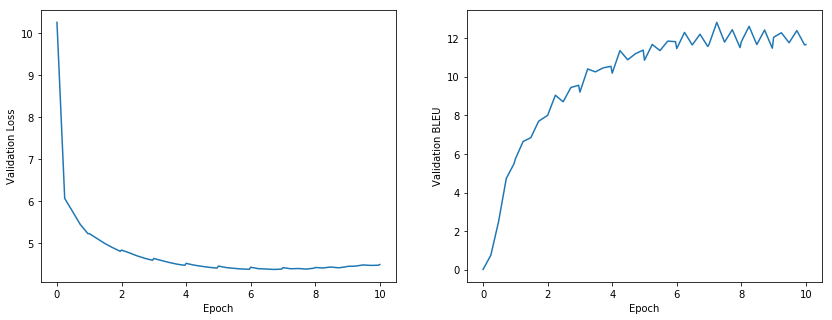

In [11]:
plot_single_learning_curve(experiment_results[0]['results'])

In [12]:
summarize_results(experiment_results)[['model_name', 'best_val_loss', 'best_val_bleu', 'runtime', 
                                       'total_params', 'trainable_params', 'dt_created']]

,model_name,best_val_loss,best_val_bleu,runtime,total_params,trainable_params,dt_created
0,vi-rnn-without-attn-2018-12-13 05:22:29,4.373869,12.819495,487.996425,69492144,51492144,2018-12-13 13:30:37


In [9]:
# reload model 
MODEL_NAME_TO_RELOAD = 'vi-rnn-without-attn-2018-12-13 05:22:29'
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(MODEL_NAME_TO_RELOAD), map_location=device)
model.load_state_dict(checkpoint)

In [10]:
# check performance on validation set 
val_loss, val_bleu, val_hyp_idxs, val_ref_idxs, val_source_idxs, val_hyp_tokens, val_ref_tokens, val_source_tokens,\
val_attn = evaluate(model=model, loader=loaders_full['dev'], 
                    src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Validation BLEU: {:.2f} | Validation Loss: {:.2f}".format(val_bleu, val_loss))

Validation BLEU: 12.82 | Validation Loss: 4.39


In [11]:
# print predictions on val data 
for source, ref, hyp in zip(val_source_tokens, val_ref_tokens, val_hyp_tokens): 
    print("SOURCE: {}".format(' '.join(source)))
    print("REFERENCE: {}".format(' '.join(ref)))
    print("HYPOTHESIS: {}".format(' '.join(hyp)))
    print()

SOURCE: khi tôi còn nhỏ , tôi nghĩ rằng <UNK> tiên
REFERENCE: when i was little , i thought my country
HYPOTHESIS: <SOS> as i was a , i thought , i

SOURCE: tôi đã rất tự_hào về đất_nước tôi . <EOS> <PAD>
REFERENCE: and i was very proud . <EOS> <PAD> <PAD>
HYPOTHESIS: <SOS> i &apos;ve was been proud . <EOS> was .

SOURCE: ở trường , chúng_tôi dành rất nhiều thời_gian để học
REFERENCE: in school , we spent a lot of time
HYPOTHESIS: <SOS> in the , we have a lot of time

SOURCE: mặc_dù tôi đã từng tự_hỏi không biết thế_giới bên_ngoài kia
REFERENCE: although i often wondered about the outside world ,
HYPOTHESIS: <SOS> because i i &apos;t &apos;t i , , ,

SOURCE: khi tôi lên 7 , tôi chứng_kiến cảnh người_ta <UNK>
REFERENCE: when i was seven years old , i saw
HYPOTHESIS: <SOS> when i was seven years i i i &apos;m

SOURCE: gia_đình của tôi không nghèo , và bản_thân tôi thì
REFERENCE: my family was not poor , and myself ,
HYPOTHESIS: <SOS> my my is &apos;t , , and i i

SOURCE: nhưng vào một ng


SOURCE: tôi sống gần căn_nhà này , và tôi nghĩ làm_sao
REFERENCE: i live near this house , and i thought
HYPOTHESIS: <SOS> i i this this and , and i thought

SOURCE: vào năm 2009 , tôi mất đi một người tôi
REFERENCE: in 2009 , i lost someone i loved very
HYPOTHESIS: <SOS> in 2009 , i i to a a a

SOURCE: tên bà là joan , và bà là một người
REFERENCE: her name was joan , and she was a
HYPOTHESIS: <SOS> the name is the , and she &apos;s a

SOURCE: và tôi đã nghĩ về cái chết rất nhiều ,
REFERENCE: and i thought about death a lot , and
HYPOTHESIS: <SOS> and i thought thinking was , , of ,

SOURCE: nhưng tôi đấu_tranh để duy_trì góc nhìn này trong cuộc_sống
REFERENCE: but i struggle to maintain this perspective in my
HYPOTHESIS: <SOS> but i decided decided in in in in this

SOURCE: tôi cảm_giác như thật dễ để nắm bắt_được theo ngày
REFERENCE: i feel like it &apos;s easy to get caught
HYPOTHESIS: <SOS> i &apos;m like it be be to be ,

SOURCE: vì_vậy với sự giúp_đỡ của những người bạn cũ và
R

In [16]:
# evaluate on test set 
test_loss, test_bleu, test_hyp_idxs, test_ref_idxs, test_source_idxs, test_hyp_tokens, test_ref_tokens, test_source_tokens,\
test_attn = evaluate(model=model, loader=loaders_full['test'], 
                     src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Test BLEU: {:.2f} | Test Loss: {:.2f}".format(test_bleu, test_loss))

Test BLEU: 13.87 | Test Loss: 4.29
